# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
!pip install -Uq scikit-learn
!pip install phik

In [2]:
# загружаем необходимые библиотеки и классы
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import warnings
import phik

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from phik.report import plot_correlation_matrix
from phik import report 

In [3]:
warnings.filterwarnings('ignore') # скроем лишние предупреждения

In [4]:
# загружаем данные
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')

In [5]:
# функция для описания датасета
def df_describe(df):
    display(df.head(10))
    print('Общая информация о полученном датафрейме:')
    df.info()
    print('Описание данных:')
    display(df.describe())
    print('Количество пустых значений:')
    display(df.isna().sum())
    print('Количество явных дубликатов:')
    display(df.duplicated().sum())

In [6]:
df_describe(df_0) 

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Описание данных:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Количество пустых значений:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов:


0

In [7]:
df_describe(df_1) 

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Описание данных:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Количество пустых значений:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов:


0

In [8]:
df_describe(df_2) 

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Описание данных:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Количество пустых значений:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов:


0

In [9]:
# во всех датасетах id установим как индекс для удобства последующей работы
df_0 = df_0.set_index('id')
print('Датасет geo_data_0')
display(df_0.head())

df_1 = df_1.set_index('id')
print('Датасет geo_data_1')
display(df_1.head())

df_2 = df_2.set_index('id')
print('Датасет geo_data_2')
display(df_2.head())

Датасет geo_data_0


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


Датасет geo_data_1


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


Датасет geo_data_2


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


In [10]:
# напишем функция для визуализации количественных признаков
def viz_col(df, feature):
    print(f'Описательная статистика для признака "{feature}":')
    display(df[feature].describe())
        
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Распределение признака "{feature}"', fontsize=15)
    plt.xlabel(f'Признак "{feature}"', fontsize=14)
    plt.ylabel('Плотность распределения', fontsize=14)
        
    plt.subplot(1, 2, 2)
    sns.boxplot(df[feature])
    plt.title(f'Диаграмма размаха по признаку "{feature}"', fontsize=15)
    plt.xlabel(f'Значения признака "{feature}"', fontsize=14)
        
    plt.tight_layout()
    plt.show()

Описательная статистика для признака "f0":


count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

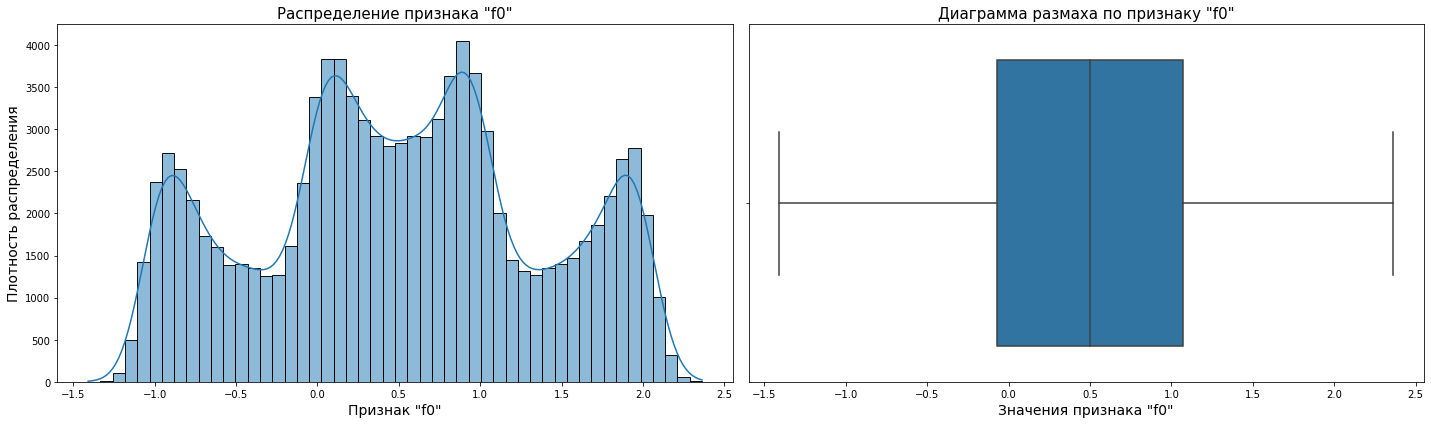

Описательная статистика для признака "f1":


count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

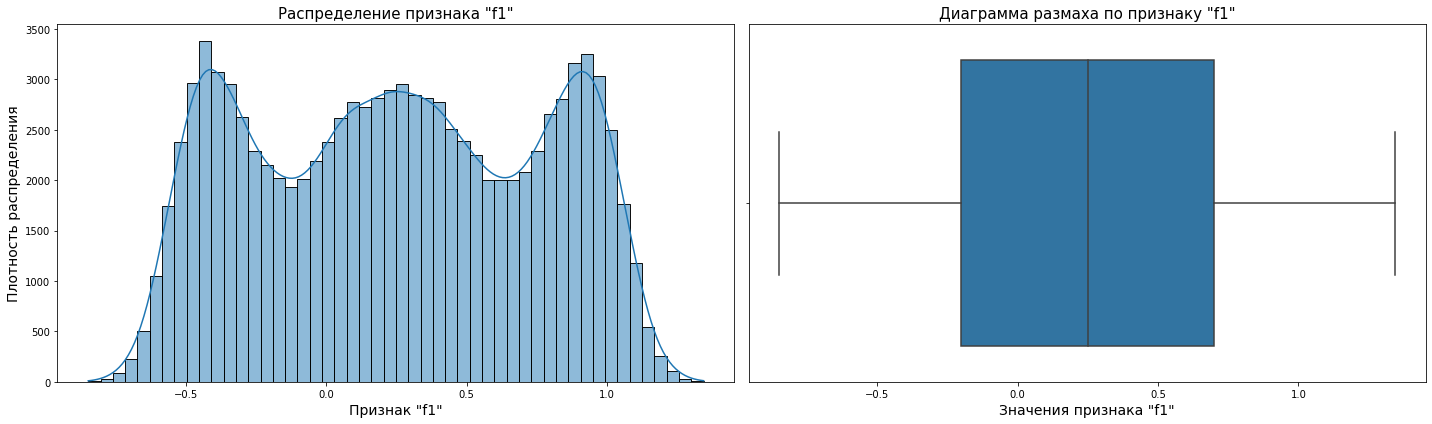

Описательная статистика для признака "f2":


count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

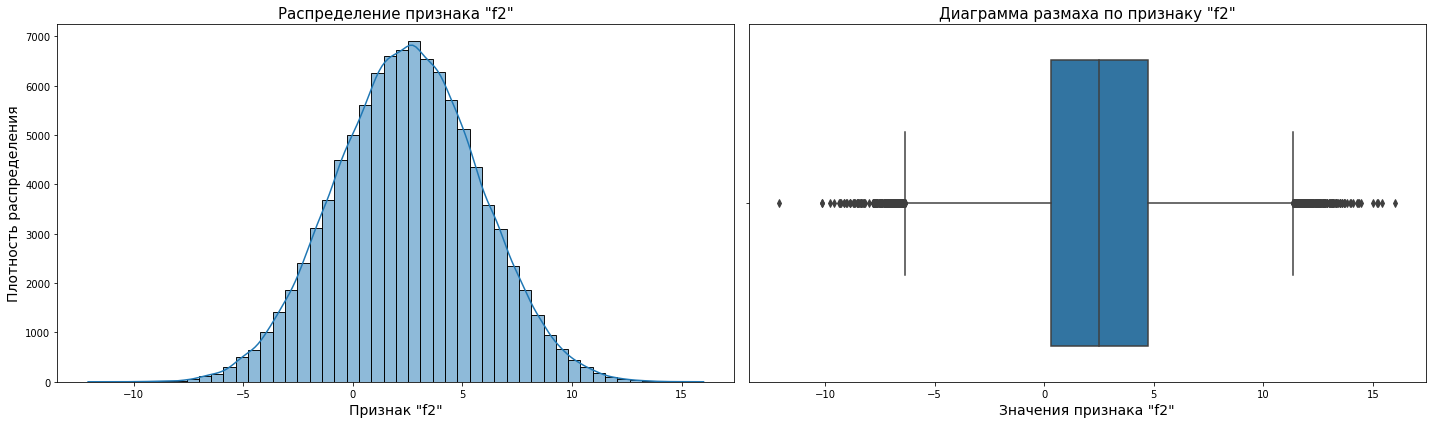

Описательная статистика для признака "product":


count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

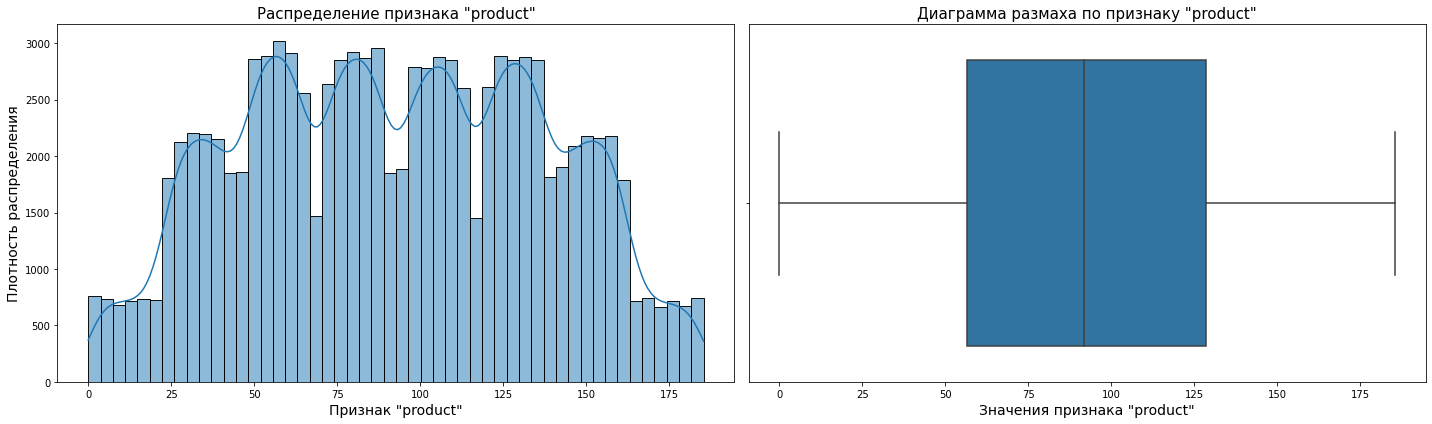

In [11]:
# визуализируем распределение данных
num_features = list(df_0.columns)

for num in num_features:
    viz_col(df_0, num)

Описательная статистика для признака "f0":


count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

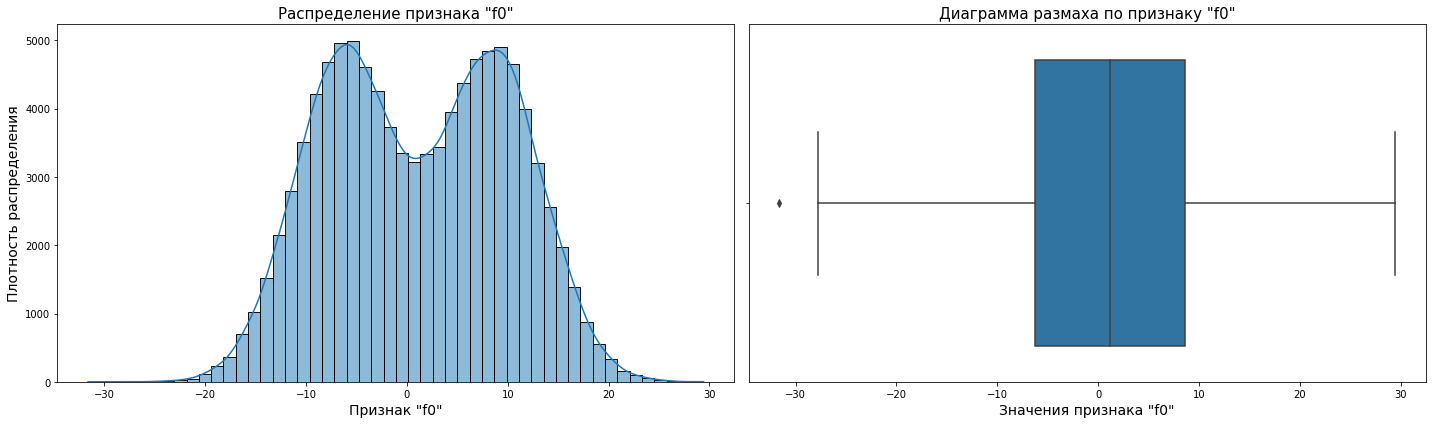

Описательная статистика для признака "f1":


count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

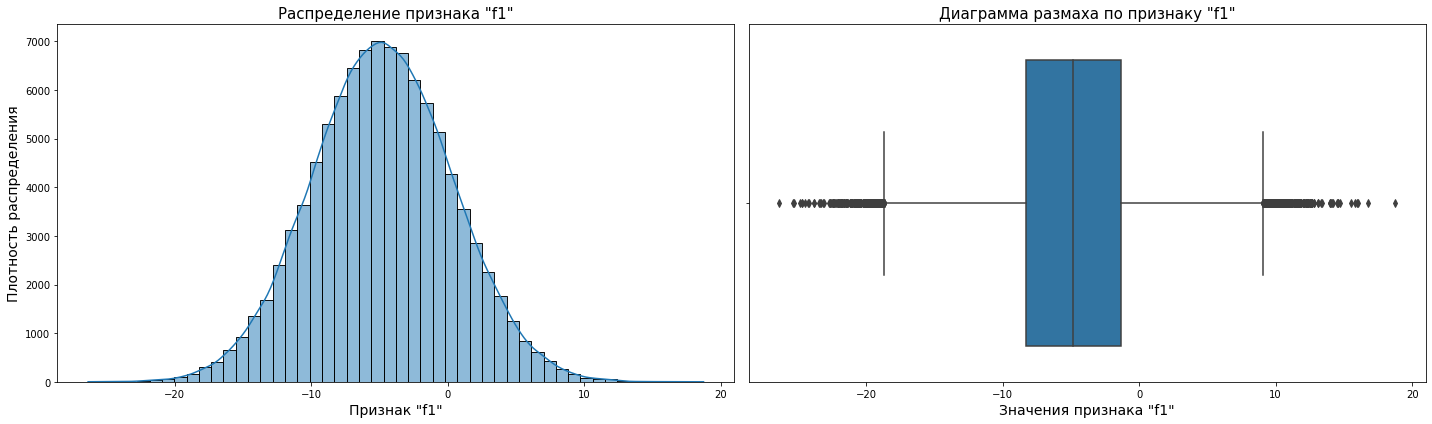

Описательная статистика для признака "f2":


count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

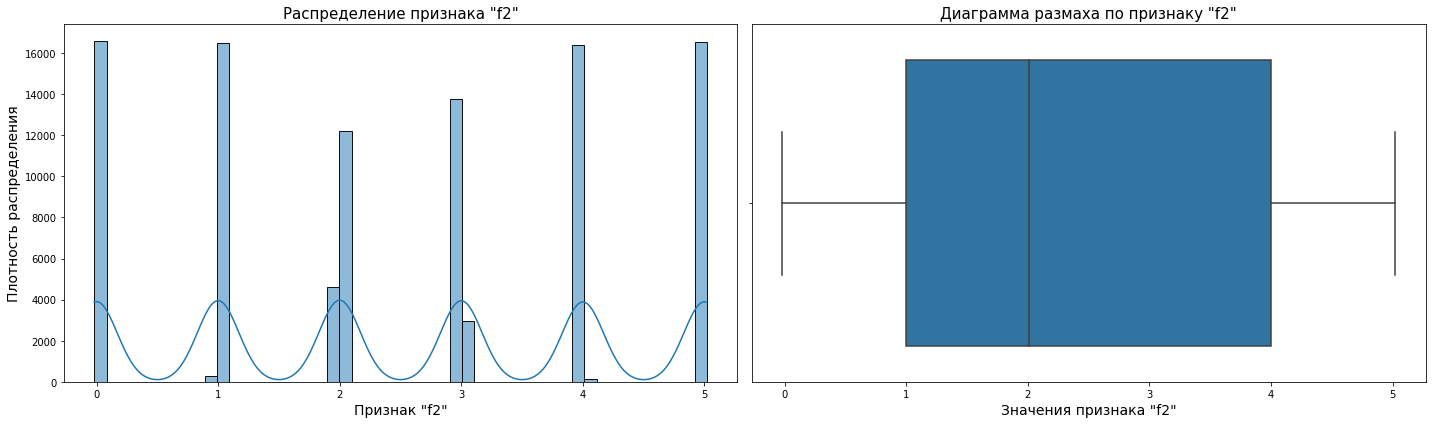

Описательная статистика для признака "product":


count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

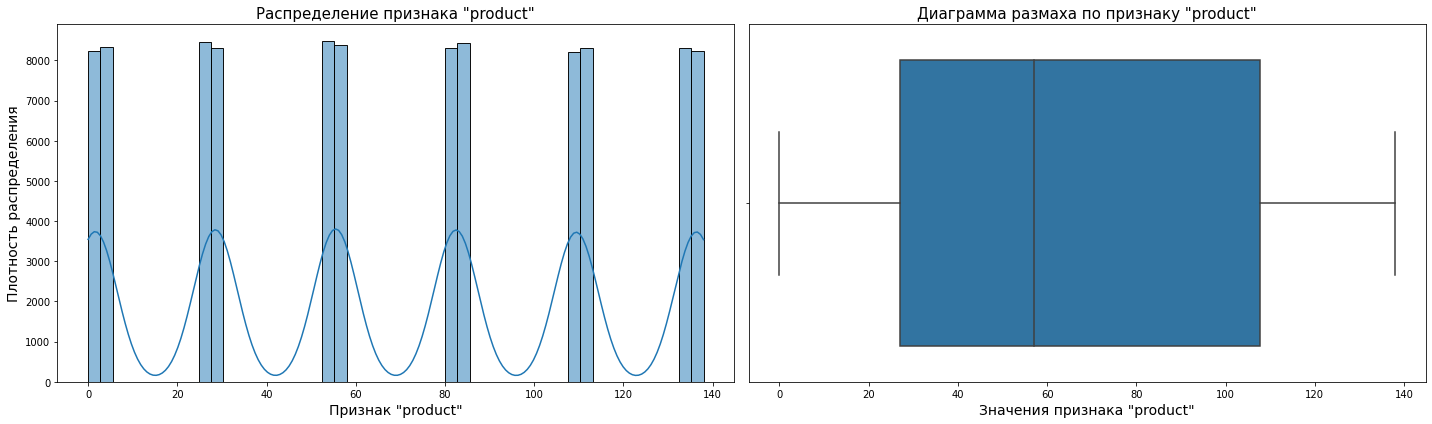

In [12]:
# визуализируем распределение данных
num_features = list(df_1.columns)

for num in num_features:
    viz_col(df_1, num)

Описательная статистика для признака "f0":


count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

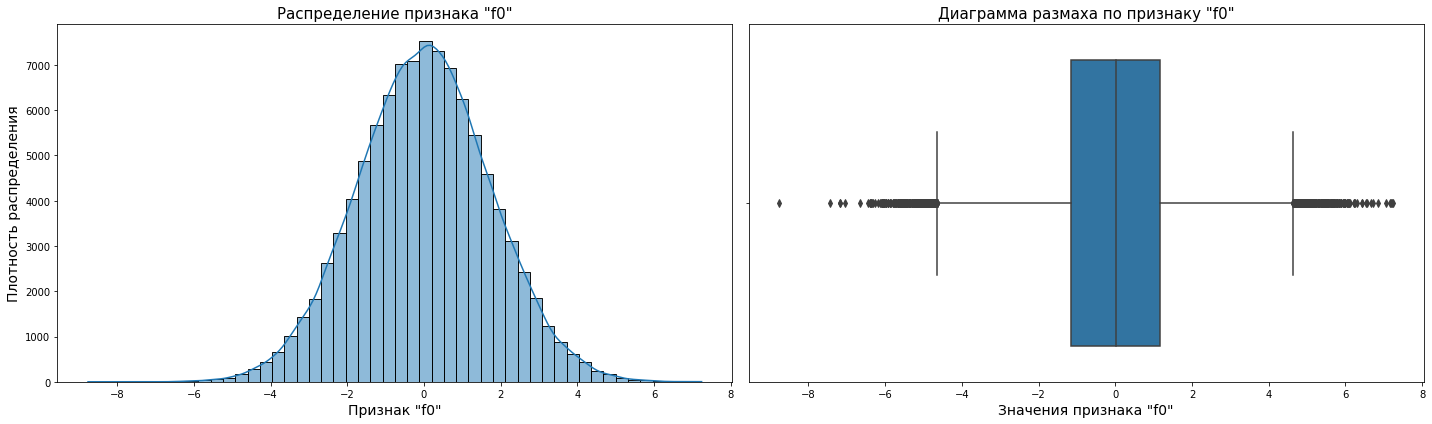

Описательная статистика для признака "f1":


count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

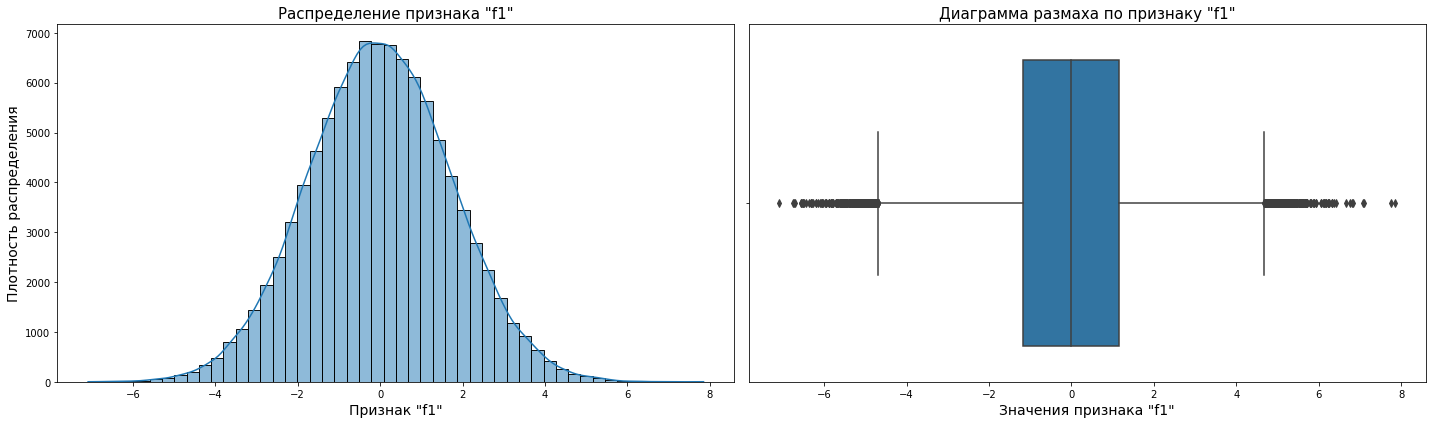

Описательная статистика для признака "f2":


count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

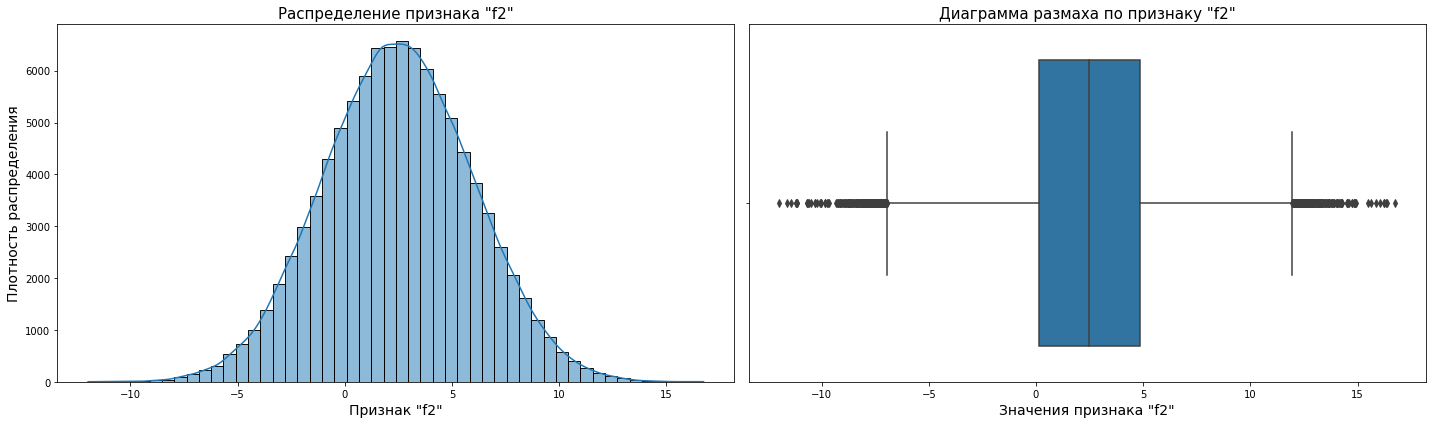

Описательная статистика для признака "product":


count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

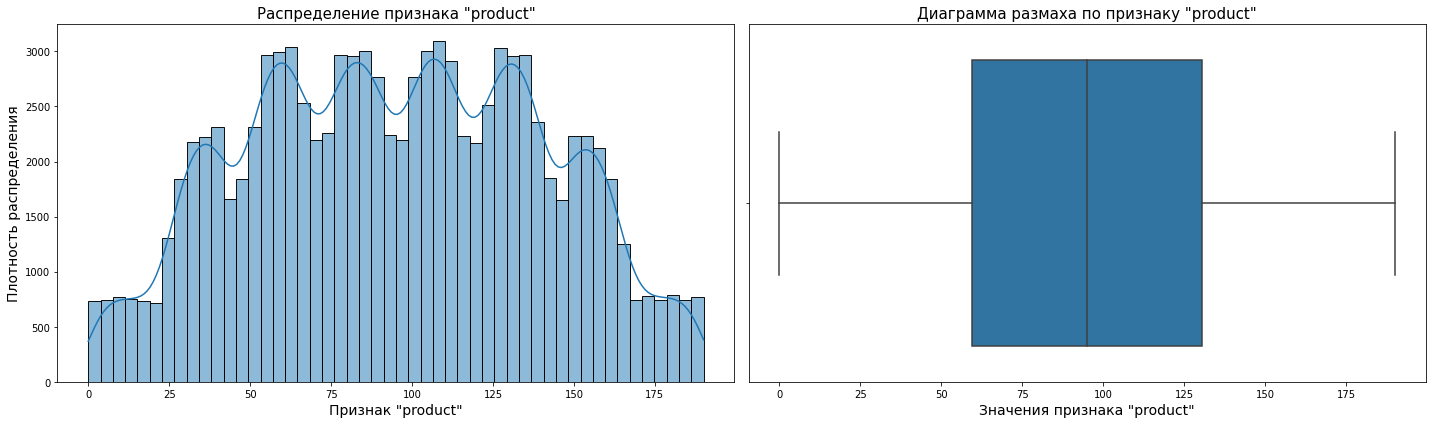

In [13]:
# визуализируем распределение данных
num_features = list(df_2.columns)

for num in num_features:
    viz_col(df_2, num)

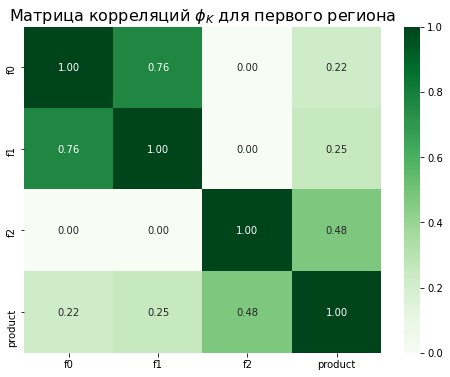

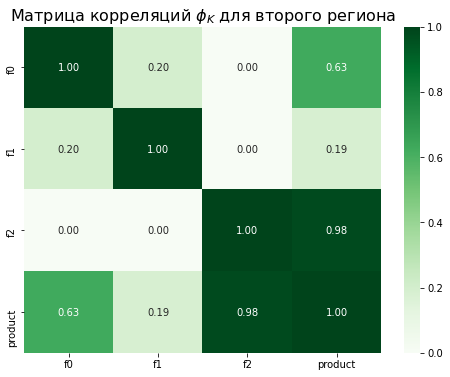

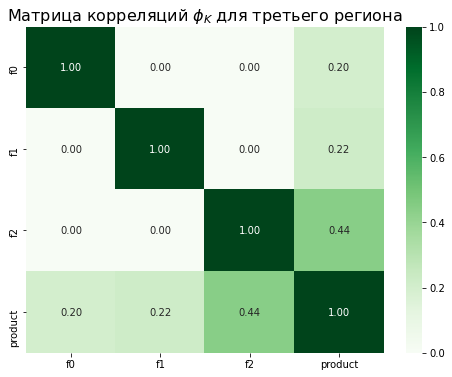

In [14]:
# смотрим матрицу корреляций
# передаем значения непрерывных признаков
interval_cols = list(df_0.columns)

corr_0 = df_0.phik_matrix(interval_cols=interval_cols, verbose=False)
corr_1 = df_1.phik_matrix(interval_cols=interval_cols, verbose=False)
corr_2 = df_2.phik_matrix(interval_cols=interval_cols, verbose=False)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_0, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$ для первого региона', fontsize=16)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_1, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$ для второго региона', fontsize=16)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_2, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$ для третьего региона', fontsize=16)
plt.show()

**Вывод:** данные загружены. Во всех трех датасетах присутвует по 100000 объектов. Пустые значения отсутсуют. Явные и неявные дубликаты отсутсвуют. Во всех датасетах `id` установлен как индекс для удобства последующей работы. Распределение признаков отличается в разных датасетах (особенно сильно отличаются значения признаков `f2` и `product` во втором датасете). В данных присутсвуют выбросы, выделяются признак `f2` в первом датасете, прзнак `f1` во втором датасете, признаки `f0`, `f1`, `f2` в третьем датасете. В последующем выполним масштабирование данных. В первом датасете отмечена наиболее сильная корреляция между целевым признаком и признаком `f2` (0.48), во втором датасете - прзнаками `f2`(0.98) и `f0` (0.68), в третьем - признаком `f2` (0.44). Мультиколлинеарности не наблюдается.

## Обучение и проверка модели

In [15]:
# напишем функция для подготовки данных и обучения модели линейной регресии
def oil_prediction(df):
   
    # выделим целевой признак
    X = df.drop(['product'], axis=1)
    y = df['product']
    
    # разбиваем  данные на обучающую и валидационную выборки в соотношении 75:25
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # масштабируем данные
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    # обучаем модель линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #делаем предсказание
    predictions = model.predict(X_valid)
    predictions = pd.Series(predictions)
    
    # расссчитываем RMSE и средний запас предсказанного сырья
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))  
    pred_mean = predictions.mean()
    
    return predictions, rmse, pred_mean, y_valid.reset_index(drop=True)

In [16]:
pred_0, rmse_0, pred_mean_0, y_valid_0 = oil_prediction(df_0)
print(f'RMSE модели в регионе 1 = {rmse_0:.3f}')
print(f'Средний запас предсказанного сырья в регионе 1 = {pred_mean_0:.3f} т. баррелей')

RMSE модели в регионе 1 = 37.757
Средний запас предсказанного сырья в регионе 1 = 92.399 т. баррелей


In [17]:
pred_1, rmse_1, pred_mean_1, y_valid_1 = oil_prediction(df_1)
print(f'RMSE модели в регионе 2 = {rmse_1:.3f}')
print(f'Средний запас предсказанного сырья в регионе 2 = {pred_mean_1:.3f} т. баррелей')

RMSE модели в регионе 2 = 0.890
Средний запас предсказанного сырья в регионе 2 = 68.713 т. баррелей


In [18]:
pred_2, rmse_2, pred_mean_2, y_valid_2 = oil_prediction(df_2)
print(f'RMSE модели в регионе 3 = {rmse_2:.3f}')
print(f'Средний запас предсказанного сырья в регионе 3 = {pred_mean_2:.3f} т. баррелей')

RMSE модели в регионе 3 = 40.146
Средний запас предсказанного сырья в регионе 3 = 94.771 т. баррелей


In [19]:
# сформируем отдельные датасеты для результатов предсказаний
df_0_pred = pd.DataFrame()
df_1_pred = pd.DataFrame()
df_2_pred = pd.DataFrame()

df_0_pred['valid'] = y_valid_0
df_0_pred['prediction'] = pred_0
display(df_0_pred.head())

df_1_pred['valid'] = y_valid_1
df_1_pred['prediction'] = pred_1
display(df_1_pred.head())

df_2_pred['valid'] = y_valid_2
df_2_pred['prediction'] = pred_2
display(df_2_pred.head())

,valid,prediction
0,122.073350,101.901017
1,48.738540,78.217774
2,131.338088,115.266901
3,88.327757,105.618618
4,36.959266,97.980185


,valid,prediction
0,0.000000,0.844738
1,53.906522,52.921612
2,134.766305,135.110385
3,107.813044,109.494863
4,0.000000,-0.047292


,valid,prediction
0,117.441301,98.301916
1,47.841249,101.592461
2,45.883483,52.449099
3,139.014608,109.922127
4,84.004276,72.411847


**Вывод:** в единой функции данные разбиты на обучающую и валидационную выборки в соотношении 75:25, обучена модель линейной регрессии (в соответсвии с заданием) и сделаны предсказания на валидационной выборке, сохранены предсказания и правильные ответы на валидационной выборке.

Наибольший показатель RMSE был в 3 регионе (40.146), наименьший - во втором (0.890). Наибольший средний запас предсказанного сырья был в 3 регионе (94.771 т. баррелей), наименьший во втором (68.713 т. баррелей).

## Подготовка к расчёту прибыли

**Условия задачи:**
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [20]:
WELLS = 500  
BEST_WELLS = 200    
BUDGET = 10000000000 
COST_BARREL = 450000
RISK_LOSS = 0.025 

In [21]:
ONE_WELL = BUDGET / BEST_WELLS
print(f'Бюджет для разработки отдной скважины: {ONE_WELL} рублей')

Бюджет для разработки отдной скважины: 50000000.0 рублей


In [22]:
BREAKEVEN_POINT = ONE_WELL / COST_BARREL
print(f'Объём сырья для безубыточной разработки новой скважины - {BREAKEVEN_POINT:.2f} тыс. баррелей')

Объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей


In [23]:
data = {
    'Регион': ['Регион 1', 'Регион 2', 'Регион 3'],
    'Сред. запас предс. сырья': [pred_mean_0, pred_mean_1, pred_mean_2],
    'Объём для безубыт. разраб.': BREAKEVEN_POINT
}

# Создание DataFrame
region_profit = pd.DataFrame(data)
region_profit['Безубыт. разраб.'] = region_profit['Сред. запас предс. сырья'] > BREAKEVEN_POINT

# Вывод таблицы
print(region_profit)

     Регион  Сред. запас предс. сырья  Объём для безубыт. разраб.  \
0  Регион 1                 92.398800                  111.111111   
1  Регион 2                 68.712878                  111.111111   
2  Регион 3                 94.771024                  111.111111   

   Безубыт. разраб.  
0             False  
1             False  
2             False  


**Вывод:** Объём сырья для безубыточной разработки новой скважины составил 111.11 тыс. баррелей. Для каждого из представленных регионнов средний запас предсказанного сырья ниже данного показателя.

## Расчёт прибыли и рисков 

In [24]:
# функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit_func(target, preds, num):
    preds_sorted = preds.sort_values(ascending=False)
    best_wells = target[preds_sorted.index][:num]
    return COST_BARREL * best_wells.sum() - BUDGET

In [25]:
# расссчитаем прибыль для каждого региона
profit_0 = profit_func(df_0_pred['valid'], df_0_pred['prediction'], BEST_WELLS)
print(f'Пибыль для региона 1: {profit_0}')

profit_1 = profit_func(df_1_pred['valid'], df_1_pred['prediction'], BEST_WELLS)
print(f'Пибыль для региона 2: {profit_1}')

profit_2 = profit_func(df_2_pred['valid'], df_2_pred['prediction'], BEST_WELLS)
print(f'Пибыль для региона 3: {profit_2}')

Пибыль для региона 1: 3359141114.462179
Пибыль для региона 2: 2415086696.681511
Пибыль для региона 3: 2598571759.374111


In [26]:
# функция для Bootstrap с 1000 выборок
def bootstrap(target, preds):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=WELLS, replace=True, random_state=state)
        preds_subsample = preds[target_subsample.index]
        values.append(profit_func(target_subsample, preds_subsample, BEST_WELLS))
    values = pd.Series(values)
    profit_mean = np.mean(values) / 10000000
    lower = values.quantile(0.025) / 10000000
    upper = values.quantile(0.975) / 10000000
    risk = (values < 0).sum() / values.count()
    
    print(f'Средняя прибыль: {profit_mean:.2f} млн.руб.')
    print(f'95% доверительный интервал: от {lower:.2f} до {upper:.2f} млн.руб.')
    print(f'Процент риска: {risk:.1%}')

In [27]:
# применяем функцию к каждому региону
print('Значения для региона 1:')
region_0 = bootstrap(df_0_pred['valid'], df_0_pred['prediction'])

Значения для региона 1:
Средняя прибыль: 43.59 млн.руб.
95% доверительный интервал: от -11.62 до 96.65 млн.руб.
Процент риска: 6.1%


In [28]:
print('Значения для региона 2:')
region_1 = bootstrap(df_1_pred['valid'], df_1_pred['prediction'])

Значения для региона 2:
Средняя прибыль: 48.97 млн.руб.
95% доверительный интервал: от 5.51 до 90.58 млн.руб.
Процент риска: 1.1%


In [29]:
print('Значения для региона 3:')
region_2 = bootstrap(df_2_pred['valid'], df_2_pred['prediction'])

Значения для региона 3:
Средняя прибыль: 40.37 млн.руб.
95% доверительный интервал: от -15.31 до 95.29 млн.руб.
Процент риска: 7.1%


**Вывод:** регион 2 наиболее подходит для разработки, так как согласно рассчетам он обладает наибольшей средней прибылью (48.97 млн.руб.) и при этом имеет наименьший риск (1.1%) по сравнению с другими регионами. У 2 региона единственный показатель риска убытков меньше 2.5%

## Общий вывод
1. Данные были загружены. Во всех трех датасетах присутвует по 100000 объектов. Пустые значения отсутсуют. Явные и неявные дубликаты отсутсвуют. Во всех датасетах `id` установлен как индекс для удобства последующей работы. Распределение признаков отличается в разных датасетах (особенно сильно отличаются значения признаков `f2` и `product` во втором датасете). В данных присутсвуют выбросы, выделяются признак `f2` в первом датасете, прзнак `f1` во втором датасете, признаки `f0`, `f1`, `f2` в третьем датасете. В последующем выполним масштабирование данных. В первом датасете отмечена наиболее сильная корреляция между целевым признаком и признаком `f2` (0.48), во втором датасете - прзнаками `f2`(0.98) и `f0` (0.68), в третьем - признаком `f2` (0.44). Мультиколлинеарности не наблюдается.
2. В единой функции данные разбиты на обучающую и валидационную выборки в соотношении 75:25, обучена модель линейной регрессии (в соответсвии с заданием) и сделаны предсказания на валидационной выборке, сохранены предсказания и правильные ответы на валидационной выборке. Наибольший показатель RMSE был в 3 регионе (40.146), наименьший - во втором (0.890). Наибольший средний запас предсказанного сырья был в 3 регионе (94.771 т. баррелей), наименьший во втором (68.713 т. баррелей).
3. Объём сырья для безубыточной разработки новой скважины составил 111.11 тыс. баррелей. Для каждого из представленных регионнов средний запас предсказанного сырья ниже данного показателя.
4. Регион 2 наиболее подходит для разработки, так как согласно рассчетам он обладает наибольшей средней прибылью (48.97 млн.руб.) и при этом имеет наименьший риск (1.1%) по сравнению с другими регионами. У 2 региона единственный показатель риска убытков меньше 2.5%